In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./csv/preprocessed/data_preprocessed_over.csv')


In [3]:
df.head()

,성별코드,연령대코드,허리둘레,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,AST,ALT,감마지티피,흡연상태,음주여부,복부비만,비만여부,고혈압,식전혈당
0,2.0,12.0,78.0,166.0,89.0,88.0,60.0,12.0,1.0,1.0,21.0,18.0,16.0,1.0,1.0,0.0,1.0,1.0,1
1,2.0,10.0,87.0,207.0,103.0,46.0,140.0,14.0,1.0,1.0,19.0,18.0,23.0,1.0,1.0,1.0,1.0,0.0,0
2,1.0,10.0,86.0,236.0,199.0,54.0,141.0,15.0,1.0,1.0,21.0,21.0,13.0,2.0,0.0,0.0,1.0,3.0,1
3,1.0,17.0,68.0,164.0,73.0,74.0,75.0,13.0,1.0,1.0,25.0,16.0,11.0,1.0,0.0,0.0,0.0,1.0,1
4,2.0,12.0,76.0,191.0,247.0,48.0,93.0,14.0,1.0,1.0,42.0,22.0,67.0,1.0,1.0,0.0,0.0,1.0,0


In [4]:
df["식전혈당"].value_counts()

2    924629
1    924629
0    924629
Name: 식전혈당, dtype: int64

# 데이터 분리 및 앙상블

In [5]:
target = df['식전혈당']
data = df.drop(['식전혈당'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0, stratify=target)

In [6]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
predict = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,predict)

print('random_forest accuracy :  {0:.4f}'.format(accuracy))

random_forest accuracy :  0.6894


이진으로 랜덤포레스트를 앙상블 모델로 돌려본 결과 0.8434 정확도가 나와 파라미터 튜닝으로 재시도.

# 하이퍼 파라미터 및 튜닝

평가를 위한 함수 설정.

In [18]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.metrics import recall_score,accuracy_score, precision_score,  roc_auc_score

# 모델 평가를 위한 함수 설정
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) 
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred)
    
    
    print('오차 행렬 :\n',confusion,', \n정확도 : {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
F1: {3:.4f}'.format(accuracy,precision,recall,f1))

In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100,200,300],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf_clf2 = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf2,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)


print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 300}
최고 예측 정확도:0.563470


In [11]:
rf_clf3 = RandomForestClassifier(n_estimators=300,max_depth=12,min_samples_leaf=8,\
                                 min_samples_split=20,random_state=0)
rf_clf3.fit(X_train,y_train)


pred2 = rf_clf3.predict(X_test)


In [19]:
get_clf_eval(y_test,pred2)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# 시각화

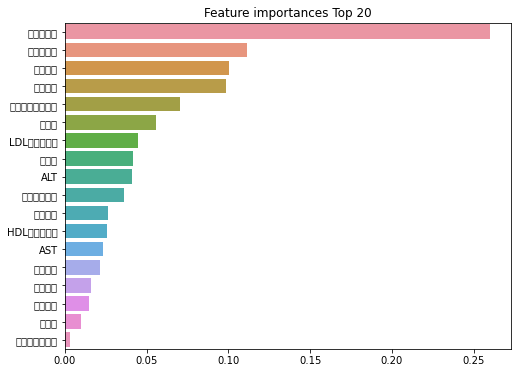

In [13]:
ftr_importances_values = rf_clf3.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]


plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

In [14]:
from sklearn.metrics import roc_curve

# 레이블 1일때 확률
ppc1 = rf_clf3.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, ppc1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step으로 추출
# thresholds[0]은 max(예츨확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arrange는 1부터 시작

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print(' 샘플 index로 추출한 임계값 : ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index],3))

ValueError: multiclass format is not supported

In [15]:
def roc_curve_plot(y_test, p_p_c1):
    # 임계값 따른 FPR, TPR  값
    fprs, tprs, thresholds = roc_curve(y_test, p_p_c1)
    
    plt.plot(fprs, tprs, label='precision')
    
    plt.plot([0,1],[0,1],'k-', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end,0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)');plt.ylabel('TPR( Recall)')
    plt.legend(); plt.grid()
    plt.show()
roc_curve_plot(y_test,ppc1)

ValueError: multiclass format is not supported